In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images_and_masks(directory):
    images = []
    masks = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        if filename.startswith('1'):  # Original images
            image = Image.open(filepath).convert('L')
            image = image.resize((128, 128))
            image = np.array(image) / 255.0
            images.append(image)
        
        elif filename.startswith('2'):  # Masks
            mask = Image.open(filepath).convert('L')
            mask = mask.resize((128, 128))
            mask = np.array(mask) / 255.0
            masks.append(mask)
    
    return np.array(images), np.array(masks)

selected_images_dir = 'selected_images_1500'
images, masks = load_images_and_masks(selected_images_dir)

# Check consistency
def check_consistency(images, masks):
    if len(images) != len(masks):
        print("Number of images and masks are not consistent.")
        return False
    else:
        print("Number of images and masks are consistent.")
        return True

if not check_consistency(images, masks):
    exit()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)




Number of images and masks are consistent.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, PReLU, Add, concatenate, MaxPooling2D

def vnet_2d(input_shape):
    def vnet_block(x, num_filters):
        conv = Conv2D(num_filters, kernel_size=(5, 5), padding='same')(x)
        conv = BatchNormalization()(conv)
        conv = PReLU()(conv)
        conv = Conv2D(num_filters, kernel_size=(5, 5), padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = PReLU()(conv)
        return conv

    inputs = Input(input_shape)
    
    # Encoder
    conv1 = vnet_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = vnet_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = vnet_block(pool2, 64)
    
    # Bottleneck
    conv4 = vnet_block(conv3, 128)
    
    # Decoder
    up5 = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv2])
    conv5 = vnet_block(up5, 64)
    
    up6 = Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv1])
    conv6 = vnet_block(up6, 32)
    
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(conv6)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Define input shape
input_shape = (128, 128, 1)

# Create the V-Net model
vnet_model = vnet_2d(input_shape)


2024-08-26 22:54:48.219065: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 22:54:48.299856: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 22:54:48.602959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 22:54:50.194417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Compile the V-Net model
vnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [4]:
# Train the V-Net model
history = vnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=4)

# Evaluate the V-Net model
loss, accuracy = vnet_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2529 - loss: 0.6672 - val_accuracy: 0.3417 - val_loss: 0.6153
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3000 - loss: 0.6248 - val_accuracy: 0.3420 - val_loss: 0.5934
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 977ms/step - accuracy: 0.2810 - loss: 0.6255 - val_accuracy: 0.3420 - val_loss: 0.5908
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 962ms/step - accuracy: 0.3201 - loss: 0.6103 - val_accuracy: 0.3420 - val_loss: 0.5860
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 960ms/step - accuracy: 0.3317 - loss: 0.5825 - val_accuracy: 0.3418 - val_loss: 0.5962
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 969ms/step - accuracy: 0.2914 - loss: 0.6131 - val_accuracy: 0.3353 - val_loss: 0.6033
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 973ms/step - accuracy: 0.3288 - loss: 0.5951 - val_accuracy: 0.3420 - val_loss: 0.5888
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2945 - loss: 0.6113 - val_accuracy: 0.3

In [10]:
from tensorflow.keras.models import Model
import numpy as np

# Select the layer from which you want to extract features from V-Net
feature_layer_name = 'conv2d_5'  # Update this with the correct layer name from V-Net
feature_extractor_model = Model(inputs=vnet_model.input, outputs=vnet_model.get_layer(feature_layer_name).output)

# Extract features for training and testing datasets
train_features = feature_extractor_model.predict(X_train)
test_features = feature_extractor_model.predict(X_test)

# Check the shape of extracted features
print(f'Train features shape: {train_features.shape}')
print(f'Test features shape: {test_features.shape}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Train features shape: (239, 32, 32, 64)
Test features shape: (60, 32, 32, 64)


In [11]:
# Flatten the features for the ViT model
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Check the flattened feature shapes
print(f'Flattened train features shape: {train_features_flattened.shape}')
print(f'Flattened test features shape: {test_features_flattened.shape}')


Flattened train features shape: (239, 65536)
Flattened test features shape: (60, 65536)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_vit_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape for ViT
input_shape_vit = (train_features_flattened.shape[1],)  # Flattened feature shape
num_classes = 2  # Number of classes

# Create and compile Vision Transformer model
vit_model = create_vit_model(input_shape_vit, num_classes)
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.utils import to_categorical

# Convert segmentation masks to categorical labels
y_train_labels = to_categorical(y_train, num_classes=2)  # Update num_classes if necessary
y_test_labels = to_categorical(y_test, num_classes=2)

# Check the shape of the labels
print(f'Shape of y_train_labels: {y_train_labels.shape}')
print(f'Shape of y_test_labels: {y_test_labels.shape}')

# Flatten the labels for classification
y_train_labels_flattened = y_train_labels.reshape(y_train_labels.shape[0], -1, y_train_labels.shape[-1])
y_test_labels_flattened = y_test_labels.reshape(y_test_labels.shape[0], -1, y_test_labels.shape[-1])

# Check the flattened label shapes
print(f'Flattened y_train_labels shape: {y_train_labels_flattened.shape}')
print(f'Flattened y_test_labels shape: {y_test_labels_flattened.shape}')


Shape of y_train_labels: (239, 128, 128, 2)
Shape of y_test_labels: (60, 128, 128, 2)
Flattened y_train_labels shape: (239, 16384, 2)
Flattened y_test_labels shape: (60, 16384, 2)


In [14]:
# Convert pixel-level labels to image-level labels
y_train_labels_single = np.argmax(y_train_labels_flattened.mean(axis=1), axis=-1)
y_test_labels_single = np.argmax(y_test_labels_flattened.mean(axis=1), axis=-1)

# Convert to categorical for ViT
y_train_labels_single = tf.keras.utils.to_categorical(y_train_labels_single, num_classes=2)
y_test_labels_single = tf.keras.utils.to_categorical(y_test_labels_single, num_classes=2)

# Check the new shape of labels
print(f'Shape of y_train_labels_single: {y_train_labels_single.shape}')
print(f'Shape of y_test_labels_single: {y_test_labels_single.shape}')


Shape of y_train_labels_single: (239, 2)
Shape of y_test_labels_single: (60, 2)


In [15]:
# Train the Vision Transformer model
history = vit_model.fit(
    train_features_flattened, 
    y_train_labels_single, 
    validation_data=(test_features_flattened, y_test_labels_single), 
    epochs=10, 
    batch_size=4
)

# Evaluate the Vision Transformer model
loss, accuracy = vit_model.evaluate(test_features_flattened, y_test_labels_single)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.5641 - loss: 173.9659 - val_accuracy: 0.7000 - val_loss: 92.0749
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 0.5549 - loss: 256.2029 - val_accuracy: 0.3000 - val_loss: 183.0866
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 407ms/step - accuracy: 0.5809 - loss: 195.9426 - val_accuracy: 0.4167 - val_loss: 140.0842
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 407ms/step - accuracy: 0.6896 - loss: 150.1643 - val_accuracy: 0.6333 - val_loss: 30.9121
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - accuracy: 0.6550 - loss: 106.6676 - val_accuracy: 0.7333 - val_loss: 71.6608
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 398ms/step - accuracy: 0.5908 - loss: 72.1615 - val_accuracy: 0.5833 - val_loss: 29.8470
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 397ms/step - accuracy: 0.6503 - loss: 52.1630 - val_accuracy: 0.5333 - val_loss: 26.8332
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.6766 - lo

In [16]:
# Save the Vision Transformer model
vit_model.save('vit_model_vnet_norm.h5')

In [17]:
from tensorflow.keras.models import load_model

# Load the Vision Transformer model
vit_model = load_model('vit_model_vnet_norm.h5')

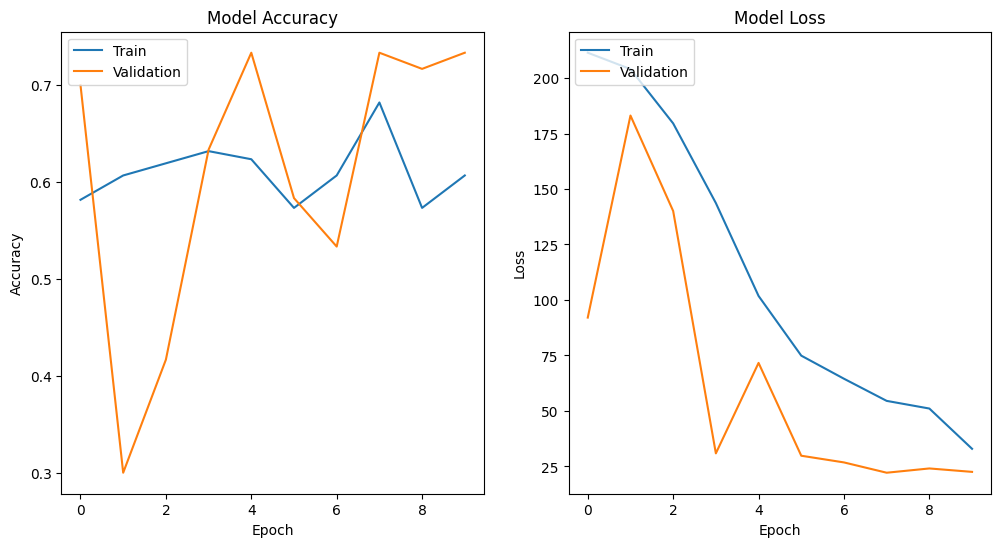

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()